In [1]:
import sys
sys.path.append('/Users/deg/PycharmProjects/probaRL')  # C:\Users\deg\PycharmProjects\probaRL\dataset.py

In [3]:

from dataset import Dataset
import gymnasium as gym                                             # pip install gymnasium
import gym_anytrading                                               # pip install gym-anytrading
from stable_baselines3.ppo.policies import MlpPolicy                # pip install stable-baselines3
from stable_baselines3 import A2C, PPO, DQN # select model
from stable_baselines3.common.evaluation import evaluate_policy
# from stable_baselines3.common.cmd_util import make_vec_env
from stable_baselines3.common.env_util import make_vec_env
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import quantstats as qs                                             # pip install QuantStats

In [52]:
# Импортируем данные о свечах с биржи, формируем датафрейм
data_binance = Dataset().get_data(days=900, symbol='BTCUSDT', tf='15m')
df = data_binance.copy()[['Open', 'High', 'Low', 'Close', 'Volume']]

In [53]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2021-07-03 00:15:00,33786.54,33914.60,33640.80,33665.01,742.103985
2021-07-03 00:30:00,33665.01,33698.84,33637.37,33675.88,272.918969
2021-07-03 00:45:00,33675.88,33748.82,33502.17,33559.56,460.033004
2021-07-03 01:00:00,33559.56,33579.80,33440.58,33526.82,287.295305
2021-07-03 01:15:00,33526.82,33609.00,33499.99,33559.13,308.712140
...,...,...,...,...,...
2023-12-20 08:45:00,42857.99,42895.53,42832.21,42832.24,235.372840
2023-12-20 09:00:00,42832.25,42842.00,42755.53,42776.99,348.122370
2023-12-20 09:15:00,42777.00,42861.29,42776.99,42848.92,286.485610


In [54]:
window_size = 50  # количество предыдущих свечей для анализа
start_index = window_size
end_index = len(df)

In [55]:
#  Создаём окружение
def create_env(df, start_index, end_index, window_size):
    env = gym.make('forex-v0', df=df, frame_bound=(start_index, end_index), window_size=window_size)
    env.trade_fee = 0.0  # комиссия за сделку
    return env
# !!!
def env_maker():
    return create_env(df, start_index, end_index, window_size)

In [63]:
# Создаём модель агента
env = make_vec_env(lambda: env_maker(), n_envs=100)  # 1000
model = PPO(MlpPolicy, env, verbose=1)
# model = A2C(MlpPolicy, env, verbose=1)

Using cpu device


In [64]:
# Оценка модели перед тренировкой
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"средняя награда:{mean_reward:.2f} +/- {std_reward:.2f}")
# средняя награда:0.00 +/- 0.00

средняя награда:0.00 +/- 0.00


In [65]:
# Обучаем модель
model.learn(total_timesteps=10_000_000)

-------------------------------
| time/              |        |
|    fps             | 13195  |
|    iterations      | 1      |
|    time_elapsed    | 15     |
|    total_timesteps | 204800 |
-------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1413        |
|    iterations           | 2           |
|    time_elapsed         | 289         |
|    total_timesteps      | 409600      |
| train/                  |             |
|    approx_kl            | 0.008133683 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.686      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 5.05e+12    |
|    n_updates            | 10          |
|    policy_gradient_loss | 8.35e-05    |
|    value_loss           | 8.48e+12    |
-----------------------------------------
--------------------

In [59]:
# Оценка модели после тренировки
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"средняя награда:{mean_reward:.2f} +/- {std_reward:.2f}")

средняя награда:0.00 +/- 0.00


In [60]:
# Сохраняем модель агента в файл
import os
save_dir = '/Users/deg/PycharmProjects/probaRL/reinforcement_learniig/tmp/'
os.makedirs(save_dir, exist_ok=True)
model.save(f'{save_dir}/agentModel')

In [61]:
# Проверяем обученую модель
env = gym.make('forex-v0', df=df, frame_bound=(start_index, end_index), window_size=window_size)
env.trade_fee = 0.0  # комиссия за сделку

obs, _ = env.reset()
while True:
    obs = obs[np.newaxis, : ]
    action, state = model.predict(obs)
    obs, reward, profit, done, info = env.step(action)
    if done:
        print('info', info)
        break

plt.figure(figsize=(300, 50))
env.unwrapped.render_all()
# env.render_all()
plt.show()

info {'total_reward': 0.0, 'total_profit': 0.8076731867195874, 'position': <Positions.Short: 0>}


c:\Users\deg\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.history to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.history` for environment variables or `env.get_wrapper_attr('history')` that will search the reminding wrappers.
  logger.warn(


c:\Users\deg\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\deg\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\deg\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\deg\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\deg\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass a

                           Strategy
-------------------------  ----------
Start Period               2021-07-03
End Period                 2023-12-20
Risk-Free Rate             0.0%
Time in Market             1.0%

Cumulative Return          -19.23%
CAGR﹪                     -5.81%

Sharpe                     -0.05
Prob. Sharpe Ratio         2.28%
Smart Sharpe               -
Sortino                    -0.05
Smart Sortino              -
Sortino/√2                 -0.04
Smart Sortino/√2           -
Omega                      0.0

Max Drawdown               -19.23%
Longest DD Days            1
Volatility (ann.)          1.04%
Calmar                     -0.3
Skew                       -293.86
Kurtosis                   86356.0

Expected Daily %           -0.0%
Expected Monthly %         -0.71%
Expected Yearly %          -6.87%
Kelly Criterion            -
Risk of Ruin               1.0%
Daily Value-at-Risk        -0.11%
Expected Shortfall (cVaR)  -0.11%

Max Consecutive Wins       0
Max C

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-12-20,2023-12-20,2023-12-20,1,-19.232681,NaN


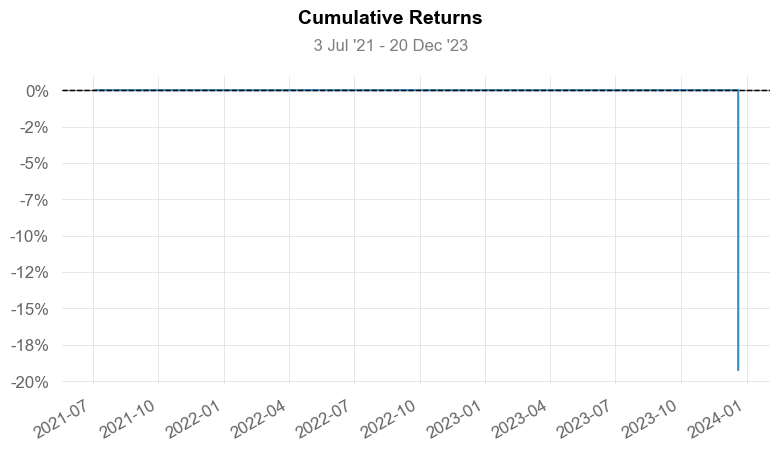

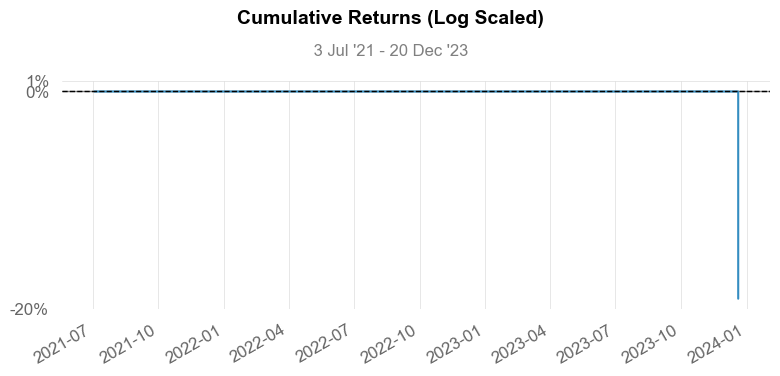

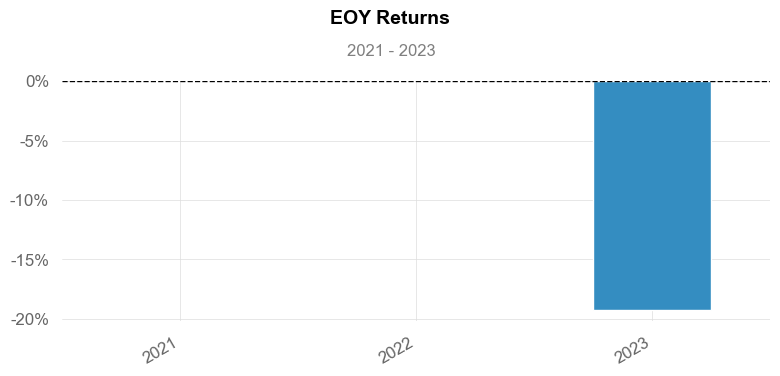

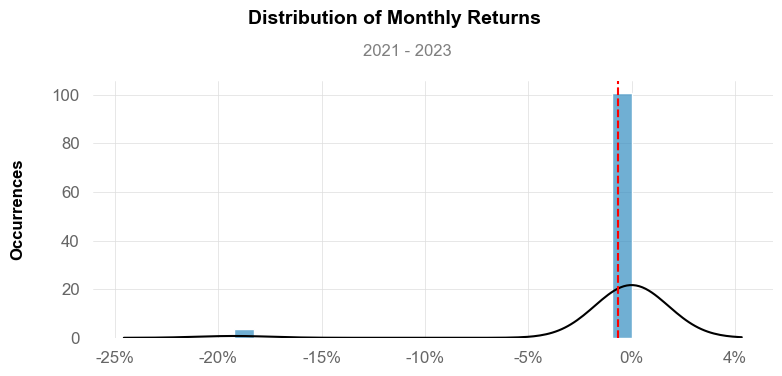

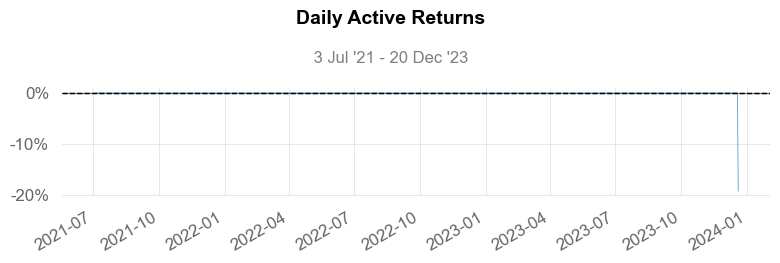

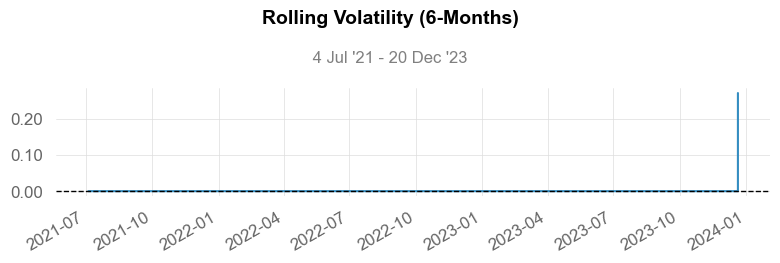

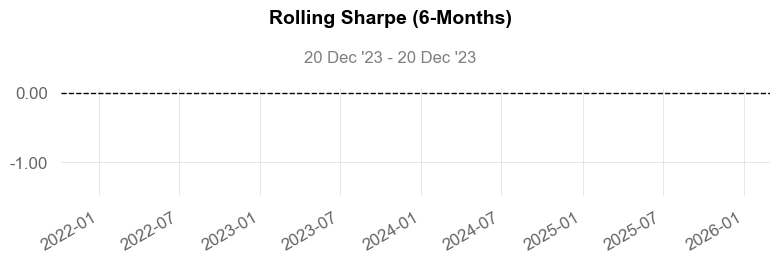

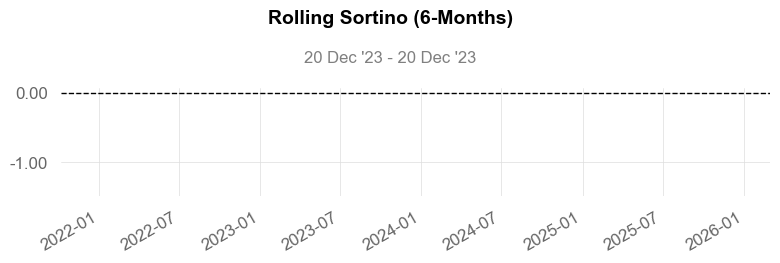

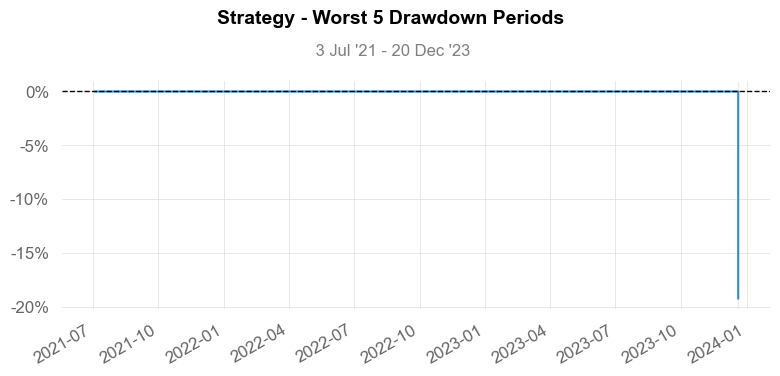

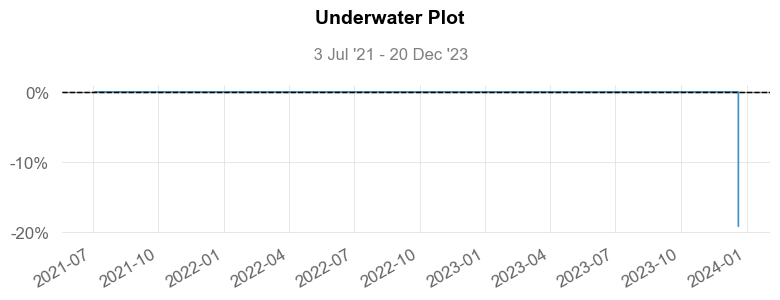

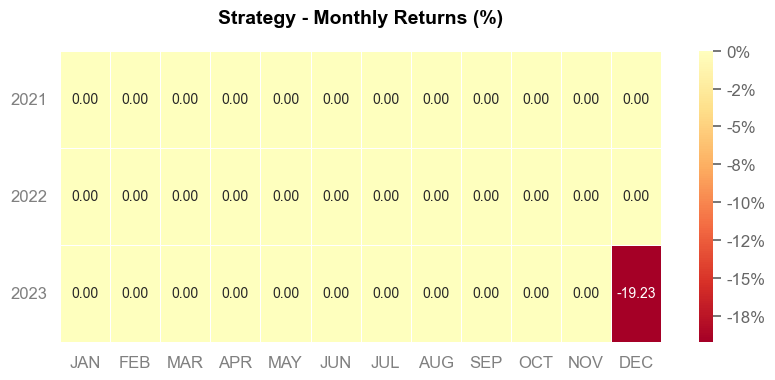

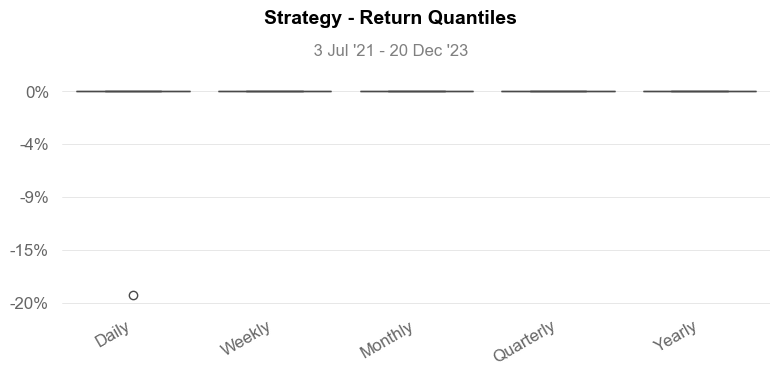

In [62]:
# Отчёт по модели
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
# qs.reports.html(returns, output='reinforcement_learning/a2c_quantstats.html')